In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from network import Network
from utils import device, get_all_preds, get_num_correct

%matplotlib inline

## when validation wasn't used during training

In [2]:
model = Network().to(device)
model.load_state_dict(
    torch.load('models/without_validation/model-run(lr=0.003, batch_size=256).ckpt',
    map_location=device)
    )

<All keys matched successfully>

In [3]:
model

Network(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=1568, out_features=256, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
  )
  (out): Linear(in_features=256, out_features=10, bias=True)
)

In [4]:
train_set = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_set = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=6000)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000)

In [5]:
model.eval()
with torch.no_grad():
    train_preds = get_all_preds(model, train_loader)
    test_preds = get_all_preds(model, test_loader)
    print(train_preds.shape)
    print(test_preds.shape)

torch.Size([60000, 10])
torch.Size([10000, 10])


In [6]:
train_correct = get_num_correct(train_preds, train_set.targets)
test_correct = get_num_correct(test_preds, test_set.targets)

print(f'Train Correct: {train_correct:5}\tTrain Accuracy: {(100*train_correct/len(train_set)):5.2f}%')
print(f'Test Correct: {test_correct:6}\tTest Accuracy: {(100*test_correct/len(test_set)):6.2f}%')

Train Correct: 59580	Train Accuracy: 99.30%
Test Correct:   9919	Test Accuracy:  99.19%


In [7]:
train_stacked = torch.stack(
    (train_set.targets, train_preds.argmax(dim=1)),
    dim=1
)
test_stacked = torch.stack(
    (test_set.targets, test_preds.argmax(dim=1)),
    dim=1
)

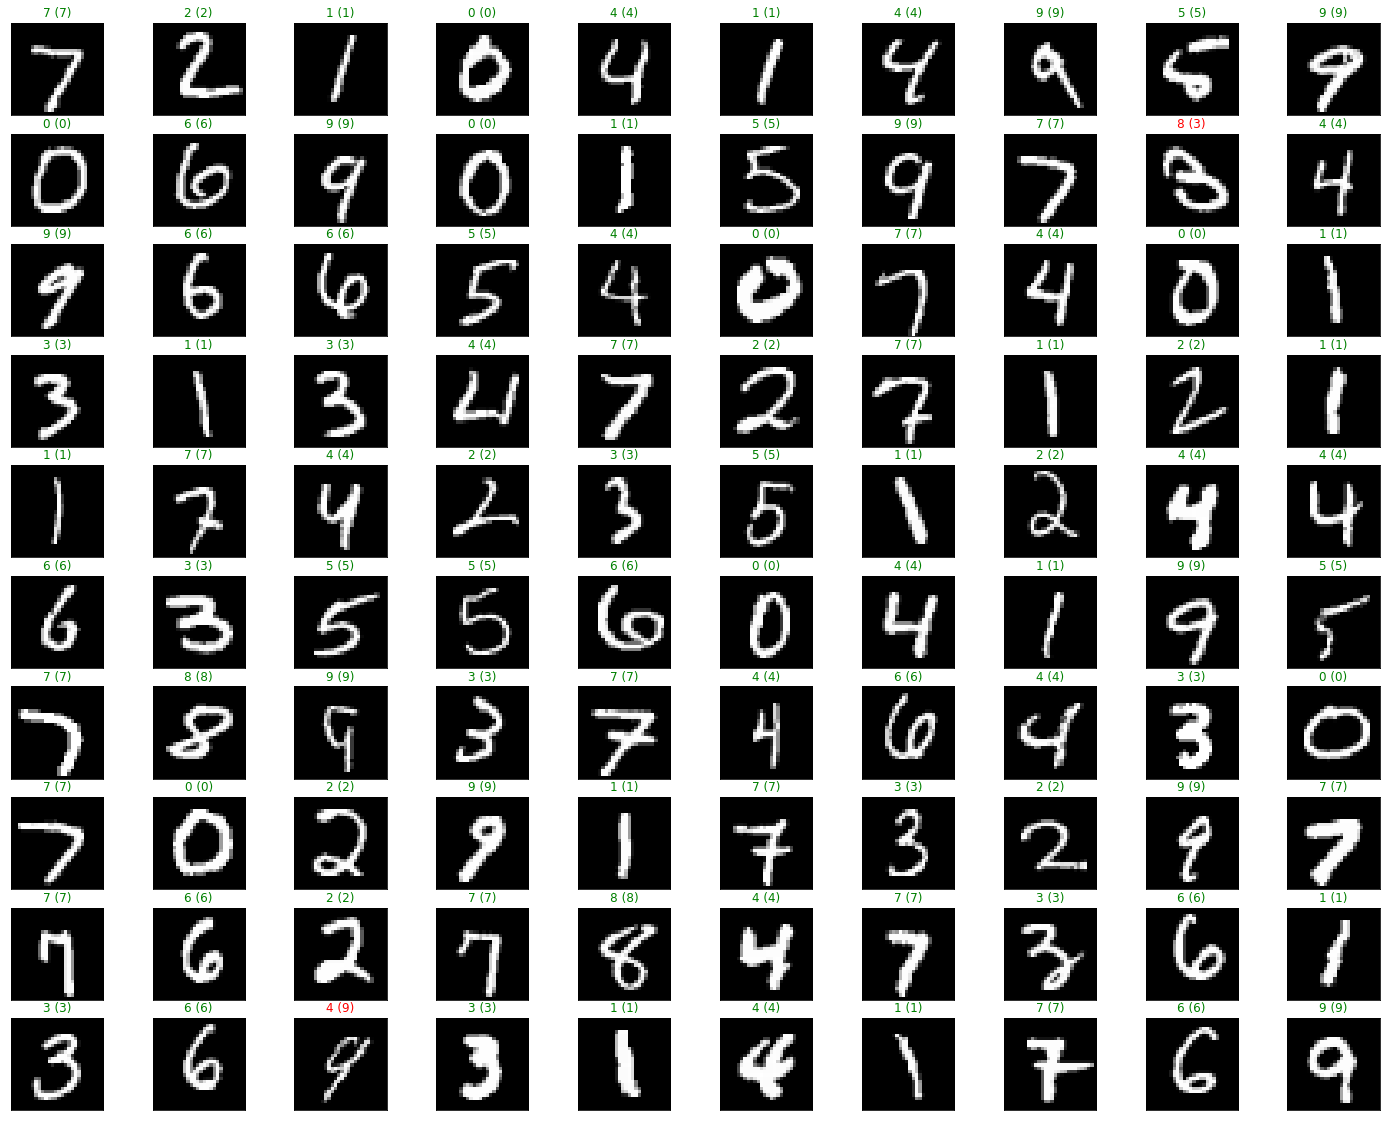

In [8]:
images, labels = next(iter(test_loader))
images = images.numpy()

fig = plt.figure(figsize=(25, 20))
for i in np.arange(100):
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[i]), cmap='gray')
    ax.set_title(f'{test_stacked[i, 1].item()} ({labels[i].item()})',
                color=('green' if test_stacked[i, 1]==labels[i] else 'red'))

plt.show()
fig.savefig('visualizations/test_results_without_val.png', bbox_inches='tight')
plt.close()

In [9]:
train_confmat = torch.zeros(10, 10, dtype=torch.int16)
for row in train_stacked:
    cl, pl = row.tolist()
    train_confmat[cl, pl] += 1

train_confmat

tensor([[5901,    3,    4,    0,    1,    0,    1,    0,   10,    3],
        [   0, 6727,    3,    1,    1,    0,    4,    4,    2,    0],
        [   0,    9, 5934,    0,    1,    0,    1,    5,    7,    1],
        [   1,    1,   14, 6082,    0,    6,    0,    5,   16,    6],
        [   0,    3,    1,    0, 5830,    0,    5,    1,    0,    2],
        [   1,    1,    2,   21,    1, 5348,   17,    0,   18,   12],
        [   8,    1,    0,    0,    3,    0, 5894,    0,   12,    0],
        [   0,   15,    8,    0,   30,    0,    0, 6183,    6,   23],
        [   2,    3,    4,    0,    5,    0,    3,    0, 5827,    7],
        [   4,    0,    0,    0,   73,    1,    0,    4,   13, 5854]],
       dtype=torch.int16)

In [10]:
test_confmat = torch.zeros(10, 10, dtype=torch.int16)
for row in test_stacked:
    cl, pl = row.tolist()
    test_confmat[cl, pl] += 1

test_confmat

tensor([[ 977,    0,    0,    0,    0,    0,    1,    1,    1,    0],
        [   0, 1133,    0,    1,    0,    0,    0,    0,    1,    0],
        [   0,    1, 1026,    1,    0,    0,    0,    3,    1,    0],
        [   0,    1,    2, 1000,    0,    2,    0,    1,    3,    1],
        [   0,    0,    0,    0,  980,    0,    1,    0,    1,    0],
        [   2,    0,    1,    6,    0,  879,    1,    0,    1,    2],
        [   6,    2,    0,    0,    1,    1,  948,    0,    0,    0],
        [   0,    2,    3,    0,    2,    0,    0, 1013,    1,    7],
        [   1,    1,    1,    0,    0,    0,    0,    1,  968,    2],
        [   0,    0,    0,    0,    9,    2,    0,    0,    3,  995]],
       dtype=torch.int16)

In [11]:
for i in range(10):
    print('Train accuracy of {:12s}:\t{:.2f}% ({}/{})'.format(
        train_set.classes[i],
        100 * (train_confmat[i, i]/train_set.targets.bincount()[i].item()),
        train_confmat[i, i],
        train_set.targets.bincount()[i].item()
    ))

Train accuracy of 0 - zero    :	99.63% (5901/5923)
Train accuracy of 1 - one     :	99.78% (6727/6742)
Train accuracy of 2 - two     :	99.60% (5934/5958)
Train accuracy of 3 - three   :	99.20% (6082/6131)
Train accuracy of 4 - four    :	99.79% (5830/5842)
Train accuracy of 5 - five    :	98.65% (5348/5421)
Train accuracy of 6 - six     :	99.59% (5894/5918)
Train accuracy of 7 - seven   :	98.69% (6183/6265)
Train accuracy of 8 - eight   :	99.59% (5827/5851)
Train accuracy of 9 - nine    :	98.40% (5854/5949)


In [12]:
for i in range(10):
    print('Test accuracy of {:12s}:\t{:.2f}% ({}/{})'.format(
        test_set.classes[i],
        100 * (test_confmat[i, i]/test_set.targets.bincount()[i].item()),
        test_confmat[i, i],
        test_set.targets.bincount()[i].item()
    ))

Test accuracy of 0 - zero    :	99.69% (977/980)
Test accuracy of 1 - one     :	99.82% (1133/1135)
Test accuracy of 2 - two     :	99.42% (1026/1032)
Test accuracy of 3 - three   :	99.01% (1000/1010)
Test accuracy of 4 - four    :	99.80% (980/982)
Test accuracy of 5 - five    :	98.54% (879/892)
Test accuracy of 6 - six     :	98.96% (948/958)
Test accuracy of 7 - seven   :	98.54% (1013/1028)
Test accuracy of 8 - eight   :	99.38% (968/974)
Test accuracy of 9 - nine    :	98.61% (995/1009)


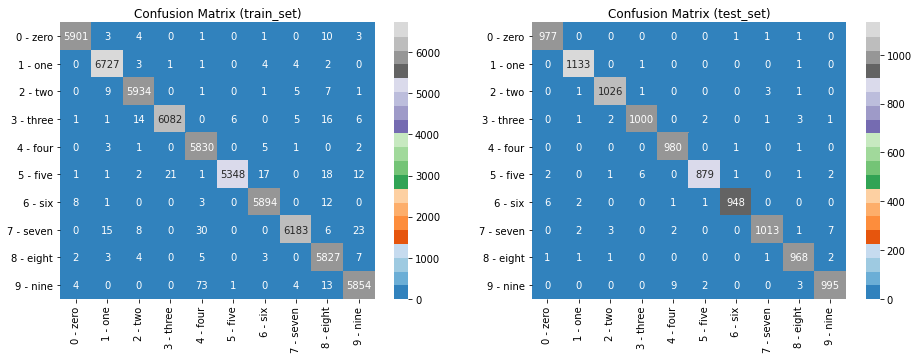

In [13]:
cm_train = pd.DataFrame(train_confmat.numpy(), index=train_set.classes, columns=train_set.classes)
cm_test = pd.DataFrame(test_confmat.numpy(), index=test_set.classes, columns=test_set.classes)

fig = plt.figure(figsize=(100, 60))
ax = fig.add_subplot(10, 12, 1)
ax = sns.heatmap(cm_train, annot=True, cmap='tab20c', fmt='d', annot_kws={'size': 10})
ax.set_title("Confusion Matrix (train_set)")
ax = fig.add_subplot(10, 12, 2)
ax = sns.heatmap(cm_test, annot=True, cmap='tab20c', fmt='d', annot_kws={'size': 10})
ax.set_title("Confusion Matrix (test_set)")

plt.show()
fig.savefig('visualizations/confusion_matrix_without_val.png', bbox='tight')
plt.close()

## when validation was used during training

In [14]:
model.load_state_dict(
    torch.load('models/with_validation/model-run(lr=0.001, batch_size=256).ckpt',
    map_location=device)
    )

<All keys matched successfully>

In [15]:
model.eval()
with torch.no_grad():
    train_preds = get_all_preds(model, train_loader)
    test_preds = get_all_preds(model, test_loader)
    print(train_preds.shape)
    print(test_preds.shape)

torch.Size([60000, 10])
torch.Size([10000, 10])


In [16]:
train_correct = get_num_correct(train_preds, train_set.targets)
test_correct = get_num_correct(test_preds, test_set.targets)

print(f'Train Correct: {train_correct:5}\tTrain Accuracy: {(100*train_correct/len(train_set)):5.2f}%')
print(f'Test Correct: {test_correct:6}\tTest Accuracy: {(100*test_correct/len(test_set)):6.2f}%')

Train Correct: 59704	Train Accuracy: 99.51%
Test Correct:   9914	Test Accuracy:  99.14%


In [17]:
val_train_stacked = torch.stack(
    (train_set.targets, train_preds.argmax(dim=1)),
    dim=1
)
val_test_stacked = torch.stack(
    (test_set.targets, test_preds.argmax(dim=1)),
    dim=1
)

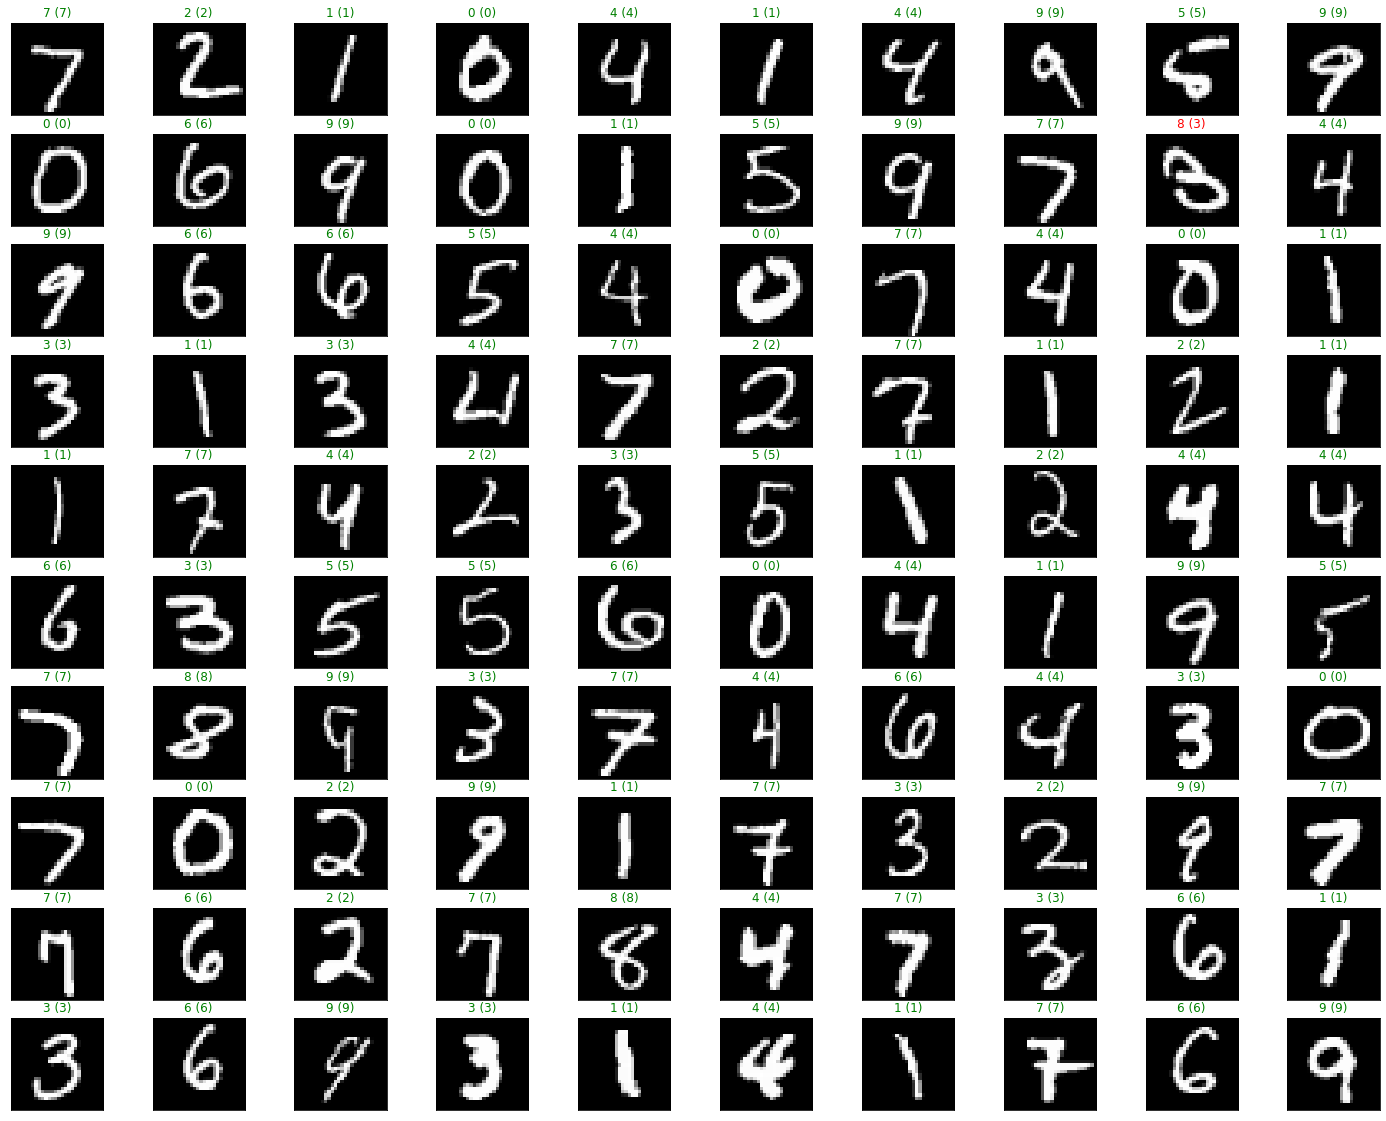

In [18]:
images, labels = next(iter(test_loader))
images = images.numpy()

fig = plt.figure(figsize=(25, 20))
for i in np.arange(100):
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[i]), cmap='gray')
    ax.set_title(f'{val_test_stacked[i, 1].item()} ({labels[i].item()})',
                color=('green' if val_test_stacked[i, 1]==labels[i] else 'red'))

plt.show()
fig.savefig('visualizations/test_results_with_val.png', bbox_inches='tight')
plt.close()

In [19]:
val_train_confmat = torch.zeros(10, 10, dtype=torch.int16)
for row in val_train_stacked:
    cl, pl = row.tolist()
    val_train_confmat[cl, pl] += 1

val_train_confmat

tensor([[5904,    0,    0,    0,    0,    0,   11,    0,    6,    2],
        [   2, 6719,    0,    0,    0,    0,    0,    9,   10,    2],
        [   2,   12, 5871,    7,    0,    0,    0,   19,   46,    1],
        [   0,    1,    0, 6107,    0,    9,    0,    2,    8,    4],
        [   0,    2,    0,    0, 5818,    0,    1,    1,    0,   20],
        [   0,    1,    0,    3,    1, 5394,    4,    0,   17,    1],
        [   2,    3,    1,    0,    3,    1, 5901,    0,    7,    0],
        [   1,    8,    2,    2,    2,    1,    0, 6220,    7,   22],
        [   0,    1,    0,    1,    2,    2,    2,    1, 5839,    3],
        [   0,    1,    0,    0,    8,    1,    0,    3,    5, 5931]],
       dtype=torch.int16)

In [20]:
val_test_confmat = torch.zeros(10, 10, dtype=torch.int16)
for row in val_test_stacked:
    cl, pl = row.tolist()
    val_test_confmat[cl, pl] += 1

val_test_confmat

tensor([[ 977,    0,    0,    0,    0,    0,    1,    0,    1,    1],
        [   0, 1132,    0,    1,    0,    0,    1,    0,    1,    0],
        [   1,    4, 1008,    3,    1,    0,    0,    5,    9,    1],
        [   0,    0,    0, 1003,    0,    3,    0,    0,    3,    1],
        [   0,    0,    0,    0,  977,    0,    1,    0,    0,    4],
        [   2,    0,    0,    3,    0,  886,    1,    0,    0,    0],
        [   3,    2,    0,    1,    1,    2,  947,    0,    2,    0],
        [   0,    3,    1,    1,    0,    1,    0, 1016,    1,    5],
        [   1,    0,    0,    1,    0,    0,    0,    0,  969,    3],
        [   0,    1,    0,    1,    3,    2,    0,    1,    2,  999]],
       dtype=torch.int16)

In [21]:
for i in range(10):
    print('Test accuracy of {:12s}:\t{:.2f}% ({}/{})'.format(
        test_set.classes[i],
        100 * (val_test_confmat[i, i]/test_set.targets.bincount()[i].item()),
        val_test_confmat[i, i],
        test_set.targets.bincount()[i].item()
    ))

Test accuracy of 0 - zero    :	99.69% (977/980)
Test accuracy of 1 - one     :	99.74% (1132/1135)
Test accuracy of 2 - two     :	97.67% (1008/1032)
Test accuracy of 3 - three   :	99.31% (1003/1010)
Test accuracy of 4 - four    :	99.49% (977/982)
Test accuracy of 5 - five    :	99.33% (886/892)
Test accuracy of 6 - six     :	98.85% (947/958)
Test accuracy of 7 - seven   :	98.83% (1016/1028)
Test accuracy of 8 - eight   :	99.49% (969/974)
Test accuracy of 9 - nine    :	99.01% (999/1009)


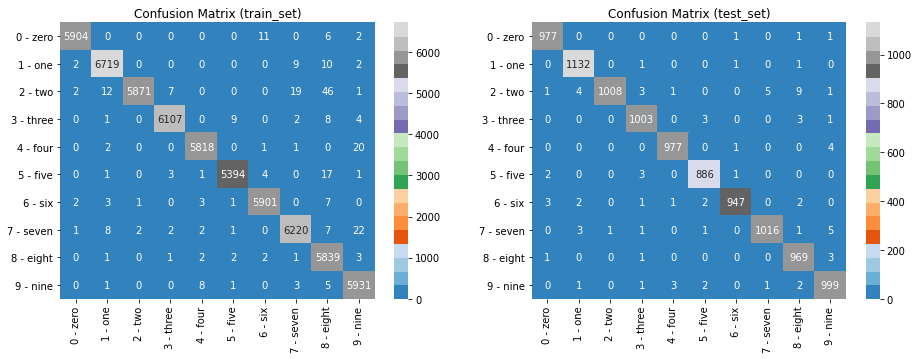

In [22]:
cm_train = pd.DataFrame(val_train_confmat.numpy(), index=train_set.classes, columns=train_set.classes)
cm_test = pd.DataFrame(val_test_confmat.numpy(), index=test_set.classes, columns=test_set.classes)

fig = plt.figure(figsize=(100, 60))
ax = fig.add_subplot(10, 12, 1)
ax = sns.heatmap(cm_train, annot=True, cmap='tab20c', fmt='d', annot_kws={'size': 10})
ax.set_title("Confusion Matrix (train_set)")
ax = fig.add_subplot(10, 12, 2)
ax = sns.heatmap(cm_test, annot=True, cmap='tab20c', fmt='d', annot_kws={'size': 10})
ax.set_title("Confusion Matrix (test_set)")

plt.show()
fig.savefig('visualizations/confusion_matrix_with_val.png', bbox='tight')
plt.close()